<a href="https://colab.research.google.com/github/jalorenzo/SparkNotebookColab/blob/master/BDF_04_Operations_on_DataFrames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#00 - Configuration of Apache Spark on Collaboratory


###Installing Java, Spark, and Findspark


---


This code installs Apache Spark 2.2.1, Java 8, and [Findspark](https://github.com/minrk/findspark), a library that makes it easy for Python to find Spark.

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget  http://apache.osuosl.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz  
!tar xf spark-3.3.1-bin-hadoop3.tgz  
!rm spark-3.3.1-bin-hadoop3.tgz    
!pip install -q findspark

### Set Environment Variables
Set the locations where Spark and Java are installed.

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark/"
os.environ["DRIVE_DATA"] = "/content/gdrive/My Drive/Enseignement/2022-2023/ING3/HPDA/BigDataFrameworks/data/"

!rm /content/spark
!ln -s /content/spark-3.3.1-bin-hadoop3 /content/spark
!export SPARK_HOME=/content/spark
!export PATH=$PATH:$SPARK_HOME/bin:$SPARK_HOME/sbin
!echo $SPARK_HOME
!env |grep  "DRIVE_DATA"

### Start a SparkSession
This will start a local Spark session.

In [2]:
!python -V

#import findspark
#findspark.init()

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

# Example: shows the PySpark version
print("PySpark version {0}".format(sc.version))

# Example: parallelise an array and show the 2 first elements
sc.parallelize([2, 3, 4, 5, 6]).cache().take(2)

Python 3.10.9
PySpark version 3.3.0


[2, 3]

In [2]:
from pyspark.sql import SparkSession
# We create a SparkSession object (or we retrieve it if it is already created)
spark = SparkSession \
.builder \
.appName("My application") \
.config("spark.some.config.option", "some-value") \
.master("local[4]") \
.getOrCreate()
# We get the SparkContext
sc = spark.sparkContext

/usr/local/lib/python3.9/dist-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/25 13:00:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/25 13:00:05 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')



---


# 04 - Operations with DataFrames

We are going to see different operations that can be performed with DataFrames:

  - Row filtering
  - Sorting and grouping
  - Joins
  - Scalar functions and aggregations
  - Using them with complex types
  - Window functions
  - User-defined functions
 
We will end up seeing how to use SQL requests on DataFrames
  

As for reading, Spark can save DateFrames in multiple formats:

- CSV, JSON, Parquet, Hadoop...

It can write them as well on a database

In [3]:
import os
os.environ["DRIVE_DATA"] = "./data/"
#Retrieve a DataFrame reading it from the Parquet format
dfSE = spark.read\
            .format("parquet")\
            .option("mode", "FAILFAST")\
            .load(os.environ["DRIVE_DATA"] + "dfSE.parquet")
dfSE.cache()

DataFrame[nComs: int, lastActivity: timestamp, userId: bigint, body: string, score: int, Creation_date: timestamp, numViewed: int, title: string, tags: string, nAnswers: int, acceptedAnswerId: bigint, postType: tinyint, id: bigint]

In [4]:
dfSE.show(5)
dfSE.printSchema()

+-----+--------------------+------+--------------------+-----+--------------------+---------+--------------------+--------------------+--------+----------------+--------+----+
|nComs|        lastActivity|userId|                body|score|       Creation_date|numViewed|               title|                tags|nAnswers|acceptedAnswerId|postType|  id|
+-----+--------------------+------+--------------------+-----+--------------------+---------+--------------------+--------------------+--------+----------------+--------+----+
|    4|2013-11-11 18:21:...|    17|&lt;p&gt;The infi...|   23|2013-11-10 19:37:...|        0|                null|                null|       0|            null|       2|1165|
|    5|2013-11-10 20:31:...|    12|&lt;p&gt;Come cre...|    1|2013-11-10 19:44:...|       61|Cosa sapreste dir...| &lt;word-choice&gt;|       1|            null|       1|1166|
|    2|2013-11-10 20:31:...|    17|&lt;p&gt;Il verbo...|    5|2013-11-10 19:58:...|        0|                null|      

## Filter operations

In [9]:
# Select those posts that contain the word 'Italiano' in their body
from pyspark.sql.functions import col

colBody = col("body")
dfItaliano = dfSE.filter(colBody.like('%Italiano%'))

print("Number of posts with the word Italiano: {0}\n".format(dfItaliano.count()))

print("Show the first line")
dfItaliano.take(1)

Number of posts with the word Italiano: 46

Show the first line


[Row(nComs=0, lastActivity=datetime.datetime(2013, 11, 11, 21, 44, 11, 903000), userId=8, body="&lt;p&gt;&lt;strong&gt;Comma + ellipsis&lt;/strong&gt; is used mainly for listing the numbers (as you would do in mathematics: &lt;em&gt;1,2,3,...&lt;/em&gt;). Still, there should be no space between comma and ellipsis.&lt;br&gt;&lt;strong&gt;Ellipsis only&lt;/strong&gt; is used for listing the words (see the grammar examples &lt;a href=&quot;http://books.google.se/books?id=BCRXQfia26wC&amp;amp;pg=PA73&amp;amp;dq=puntini%20sospensione&amp;amp;hl=en&amp;amp;sa=X&amp;amp;ei=QUyBUp-UBejy4QTc5YHoBA&amp;amp;ved=0CC8Q6AEwAA#v=onepage&amp;amp;q=puntini%20sospensione&amp;amp;f=false&quot; rel=&quot;nofollow&quot;&gt;here&lt;/a&gt; or &lt;a href=&quot;http://books.google.se/books?id=Xe2pkxDqG20C&amp;amp;pg=PA206&amp;amp;dq=puntini%20sospensione&amp;amp;hl=en&amp;amp;sa=X&amp;amp;ei=QUyBUp-UBejy4QTc5YHoBA&amp;amp;ved=0CGcQ6AEwBw#v=onepage&amp;amp;q=puntini%20sospensione&amp;amp;f=false&quot; rel=&quot

In [10]:
# Retrieve the questions (postType == 1) which have an accepted reply (acceptedAnswerID != null)
# Note: where() is an alias of filter()

colPostType = col("postType")
colAcceptedReplyId = col("acceptedAnswerId")

dfQuestionWithAcceptedReply = dfSE\
                    .where((colPostType == 1) & (colAcceptedReplyId.isNotNull()))\
                    .withColumnRenamed("Creation_date", "Date_of_creation")

print("Number of questions with an accepted reply: {0}"\
      .format(dfQuestionWithAcceptedReply.count()))

dfQuestionWithAcceptedReply.cache()      

dfQuestionWithAcceptedReply\
        .select("Date_of_creation", colPostType.alias("Post Type"), colAcceptedReplyId)\
        .show(truncate=False)

Number of questions with an accepted reply: 222
+-----------------------+---------+----------------+
|Date_of_creation       |Post Type|acceptedAnswerId|
+-----------------------+---------+----------------+
|2013-11-10 22:03:41.027|1        |1170            |
|2013-11-11 10:28:12.613|1        |1181            |
|2013-11-11 11:31:02.343|1        |1177            |
|2013-11-11 11:39:12.703|1        |1182            |
|2013-11-11 12:58:38.137|1        |1180            |
|2013-11-11 14:43:47.487|1        |1263            |
|2013-11-11 18:19:12.253|1        |1185            |
|2013-11-11 21:01:13.34 |1        |1212            |
|2013-11-11 21:01:47.523|1        |1195            |
|2013-11-12 09:31:34.54 |1        |1202            |
|2013-11-12 10:57:21.793|1        |1216            |
|2013-11-12 11:03:26.287|1        |1207            |
|2013-11-12 13:12:01.78 |1        |1226            |
|2013-11-12 13:34:23.74 |1        |1227            |
|2013-11-12 13:38:23.663|1        |1223            

In [11]:
# Keep the entries corresponding to June 2014
from datetime import date

colCreationDate = col("Date_of_creation")

dfQuestionWithAcceptedReplyJun14 = dfQuestionWithAcceptedReply\
                    .filter((colCreationDate >= date(2014,6,1)) & 
                            (colCreationDate <= date(2014,6,30)))

dfQuestionWithAcceptedReplyJun14.select(colCreationDate, colPostType, colAcceptedReplyId).show(truncate=False)

+-----------------------+--------+----------------+
|Date_of_creation       |postType|acceptedAnswerId|
+-----------------------+--------+----------------+
|2014-06-01 13:23:00.687|1       |1994            |
|2014-06-01 13:28:46.887|1       |1993            |
|2014-06-04 07:02:38.767|1       |1997            |
|2014-06-04 12:59:36.857|1       |2010            |
|2014-06-04 20:26:02.053|1       |2004            |
|2014-06-05 12:04:44.453|1       |2006            |
|2014-06-07 19:43:33.963|1       |2012            |
|2014-06-09 08:51:01.853|1       |2016            |
|2014-06-27 14:18:10.363|1       |2025            |
|2014-06-29 18:34:55.657|1       |2031            |
+-----------------------+--------+----------------+



In [12]:
# Add a column with the ratio between the number of visits and the score of the question
colNumViews = col("numViewed")
colPoints = col("score")
dfQuestionWithAcceptedReplyRatio = dfQuestionWithAcceptedReply.withColumn("ratio", colNumViews/colPoints)

# Shows some columns with ratio > 35
colRatio = col("ratio")
dfQuestionWithAcceptedReplyRatio.filter(colRatio > 35)\
                        .select(colCreationDate, colNumViews, colPoints, colRatio)\
                        .show(truncate=False)

+-----------------------+---------+-----+------------------+
|Date_of_creation       |numViewed|score|ratio             |
+-----------------------+---------+-----+------------------+
|2013-11-11 14:43:47.487|321      |6    |53.5              |
|2013-11-12 14:14:50.85 |579      |14   |41.357142857142854|
|2013-11-14 15:44:50.99 |653      |7    |93.28571428571429 |
|2013-11-23 09:09:04.993|181      |3    |60.333333333333336|
|2013-11-23 09:15:29.247|474      |3    |158.0             |
|2013-11-26 20:08:13.423|79       |2    |39.5              |
|2013-11-27 08:05:11.63 |172      |1    |172.0             |
|2013-11-28 08:26:19.477|378      |5    |75.6              |
|2013-11-29 14:52:32.28 |57       |1    |57.0              |
|2013-12-01 18:11:27.07 |114      |1    |114.0             |
|2013-12-08 03:20:58.563|313      |5    |62.6              |
|2013-12-14 21:31:54.963|154      |4    |38.5              |
|2013-12-15 17:39:53.017|330      |7    |47.142857142857146|
|2013-12-16 13:50:19.943

## Sorting and grouping operations

In [13]:
# Sorting by viewCount
dfQuestionWithAcceptedReply.orderBy(colNumViews, ascending=False)\
                  .select(colCreationDate, colNumViews)\
                  .show(10, truncate=False)

+-----------------------+---------+
|Date_of_creation       |numViewed|
+-----------------------+---------+
|2014-03-06 19:51:16.093|711      |
|2013-11-14 15:44:50.99 |653      |
|2013-11-12 14:14:50.85 |579      |
|2013-11-05 21:57:56.813|557      |
|2013-12-16 13:50:19.943|489      |
|2013-11-23 09:15:29.247|474      |
|2014-09-10 05:53:39.14 |465      |
|2013-12-19 23:01:35.55 |463      |
|2014-08-20 06:06:02.457|455      |
|2013-12-27 14:45:38.683|445      |
+-----------------------+---------+
only showing top 10 rows



In [14]:
# Grouping by the userId column
colUserId = col("userId")
groupByUser = dfQuestionWithAcceptedReply.groupBy(colUserId)
print(type(groupByUser))

<class 'pyspark.sql.group.GroupedData'>


In [15]:
print("DataFrame with the number of posts by user")
dfPostsByUser = groupByUser.count()
dfPostsByUser.printSchema()

colNPosts = col("count")
dfPostsByUser.select(colUserId.alias("User number"), 
                        colNPosts.alias("Number of posts"))\
                .orderBy(colUserId).show(10)

DataFrame with the number of posts by user
root
 |-- userId: long (nullable = true)
 |-- count: long (nullable = false)

+-----------+---------------+
|User number|Number of posts|
+-----------+---------------+
|          8|              4|
|         12|             20|
|         17|              3|
|         18|              2|
|         22|             11|
|         37|              2|
|         48|              1|
|         53|              2|
|         56|              5|
|         61|              1|
+-----------+---------------+
only showing top 10 rows



In [16]:
print("DataFrame with the average number of views per user")
dfAvgPerUser = groupByUser.avg("numViewed")
dfAvgPerUser.orderBy(colUserId).show(10)

DataFrame with the average number of views per user
+------+------------------+
|userId|    avg(numViewed)|
+------+------------------+
|     8|             168.0|
|    12|             141.1|
|    17| 90.66666666666667|
|    18|             144.0|
|    22|201.36363636363637|
|    37|             312.0|
|    48|             127.0|
|    53|              70.5|
|    56|             115.6|
|    61|             338.0|
+------+------------------+
only showing top 10 rows



In [17]:
# The 'agg' method allows grouping operations expressed as a dictionary {column_name:operation}
print("Obtain the previous tables with a single operation")
dfCountAvg = groupByUser.agg({"userId":"count", "numViewed":"avg"})
dfCountAvg.printSchema()

colCount = col("count(userId)")
colMedia = col("avg(numViewed)")
dfCountAvg.select(colUserId.alias("User number"), 
                   colCount.alias("Number of posts"), 
                   colMedia.alias("Views average"))\
                  .orderBy(colUserId).show(10)

Obtain the previous tables with a single operation
root
 |-- userId: long (nullable = true)
 |-- avg(numViewed): double (nullable = true)
 |-- count(userId): long (nullable = false)

+-----------+---------------+------------------+
|User number|Number of posts|     Views average|
+-----------+---------------+------------------+
|          8|              4|             168.0|
|         12|             20|             141.1|
|         17|              3| 90.66666666666667|
|         18|              2|             144.0|
|         22|             11|201.36363636363637|
|         37|              2|             312.0|
|         48|              1|             127.0|
|         53|              2|              70.5|
|         56|              5|             115.6|
|         61|              1|             338.0|
+-----------+---------------+------------------+
only showing top 10 rows



In [18]:
# Grouping on two columns
dfSE.groupBy(colUserId, colPostType)\
    .count()\
    .sort(colUserId, colPostType)\
    .show()

+------+--------+-----+
|userId|postType|count|
+------+--------+-----+
|     4|       1|    1|
|     4|       2|    1|
|     5|       2|   10|
|     6|       2|    2|
|     8|       1|    6|
|     8|       2|   36|
|     8|       4|   52|
|     8|       5|   52|
|    10|       2|    1|
|    12|       1|   95|
|    12|       2|   14|
|    13|       2|    1|
|    14|       2|    2|
|    15|       2|    2|
|    17|       1|    3|
|    17|       2|   28|
|    18|       1|    4|
|    18|       2|   27|
|    19|       2|   13|
|    22|       1|   14|
+------+--------+-----+
only showing top 20 rows



A description of the functions used with GroupedData can be found on https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html#grouping

### Advanced grouping

It is possible to group data on more than one column: `Rollups` and `Cube`

#### Rollups

Grouping by multiple columns, including aggregations by the first column.

In [19]:
# For each user, count the number of questions (postType == 1) and the number of replies (postType == 2)
rollupPerUserAndPostType = dfSE.rollup("userId", "postType")
print(type(rollupPerUserAndPostType))

<class 'pyspark.sql.group.GroupedData'>


In [20]:
# DataFrame with the number of posts per user and 'Question' post type
# Null fields are aggregation fields. For example:
# null null = all posts
# 4    null = all posts from user with id 4
# 4    1    = all posts of type 1 from user with id 4
# NOTE: disregard posts with types 4 and 5.
dfPostPerUserAndType = rollupPerUserAndPostType.count()
dfPostPerUserAndType.printSchema()
dfPostPerUserAndType.select(colUserId.alias("User number"), 
                             colPostType.alias("Post type"),
                             colNPosts.alias("Number of posts"))\
                     .orderBy(colUserId,colPostType)\
                     .show(100)

root
 |-- userId: long (nullable = true)
 |-- postType: byte (nullable = true)
 |-- count: long (nullable = false)

+-----------+---------+---------------+
|User number|Post type|Number of posts|
+-----------+---------+---------------+
|       null|     null|           1261|
|          4|     null|              2|
|          4|        1|              1|
|          4|        2|              1|
|          5|     null|             10|
|          5|        2|             10|
|          6|     null|              2|
|          6|        2|              2|
|          8|     null|            146|
|          8|        1|              6|
|          8|        2|             36|
|          8|        4|             52|
|          8|        5|             52|
|         10|     null|              1|
|         10|        2|              1|
|         12|     null|            109|
|         12|        1|             95|
|         12|        2|             14|
|         13|     null|              1|
|   

#### Cubes

Similar to Rollups, but going through all dimensions.

In [21]:
groupByUserAndPostType = dfSE.cube("userId", "postType")
print(type(groupByUserAndPostType))

<class 'pyspark.sql.group.GroupedData'>


In [22]:
# # DataFrame with the number of posts per user and 'Question' post type
# Null fields are aggregation fields. For example:
# null null = all posts
# null 1    = all post of type 1
# 4    null = all posts from user with id 4
# 4    1    = all posts of type 1 from user with id 4
# NOTE: disregard posts with types 4 and 5.
dfPostPerUserAndType = groupByUserAndPostType.count()
dfPostPerUserAndType.printSchema()
dfPostPerUserAndType.select(colUserId.alias("User number"), 
                             colPostType.alias("Post type"),
                             colNPosts.alias("Number of posts"))\
                     .orderBy(colUserId,colPostType)\
                     .show(100)

root
 |-- userId: long (nullable = true)
 |-- postType: byte (nullable = true)
 |-- count: long (nullable = false)

+-----------+---------+---------------+
|User number|Post type|Number of posts|
+-----------+---------+---------------+
|       null|     null|           1261|
|       null|        1|            374|
|       null|        2|            765|
|       null|        4|             64|
|       null|        5|             58|
|          4|     null|              2|
|          4|        1|              1|
|          4|        2|              1|
|          5|     null|             10|
|          5|        2|             10|
|          6|     null|              2|
|          6|        2|              2|
|          8|     null|            146|
|          8|        1|              6|
|          8|        2|             36|
|          8|        4|             52|
|          8|        5|             52|
|         10|     null|              1|
|         10|        2|              1|
|   

## Joins
Spark offers the possibility of performing multiple types of joins (as in SQL)

  - inner, outer, left outer, right outer, left semi, left anti, cross

In [23]:
# We want to join each question that has an accepted reply with the actual reply chosen as the accepted answer
# We join the colAcceptedReplyId field from the questions with the id field from the answers
dfQuestions = dfQuestionWithAcceptedReply\
                .select(colUserId, colBody, colAcceptedReplyId)\
                .withColumnRenamed("userId", "User question")\
                .withColumnRenamed("body", "Question")\
                .withColumnRenamed("acceptedAnswerId", "ID Accepted Reply")

colId = col("id")                
dfReplies = dfSE\
                .select(colId, colUserId, colBody)\
                .where(colPostType == 2)\
                .withColumnRenamed("id", "ID Reply")\
                .withColumnRenamed("userId", "User reply")\
                .withColumnRenamed("body", "Reply")

nQuestions = dfQuestions.count()
nReplies = dfReplies.count()
print("Number of questions with an accepted reply = {0}".format(nQuestions))
print("Number of replies = {0}".format(nReplies))

Number of questions with an accepted reply = 222
Number of replies = 765


In [24]:
dfQuestions.show()
dfReplies.show()

+-------------+--------------------+-----------------+
|User question|            Question|ID Accepted Reply|
+-------------+--------------------+-----------------+
|          154|&lt;p&gt;As part ...|             1170|
|           63|&lt;p&gt;When I w...|             1181|
|           63|&lt;p&gt;Suppose ...|             1177|
|           63|&lt;p&gt;Except w...|             1182|
|           63|&lt;p&gt;Comparin...|             1180|
|           22|&lt;p&gt;Many peo...|             1263|
|          159|&lt;p&gt;Sono un'...|             1185|
|            8|&lt;p&gt;The use ...|             1212|
|           17|&lt;p&gt;When wri...|             1195|
|           63|&lt;p&gt;When wri...|             1202|
|           99|&lt;p&gt;I can't ...|             1216|
|           63|&lt;p&gt;Some wor...|             1207|
|           63|&lt;p&gt;In Lomba...|             1226|
|           63|&lt;p&gt;The plur...|             1227|
|           63|&lt;p&gt;I rememb...|             1223|
|         

In [26]:
# Join expression
joinExpression = dfQuestions["ID Accepted Reply"] == dfReplies["ID Reply"]

In [27]:
# Inner join
# Include only rows for which the joinExpression is true
joinType = "inner"
dfInner = dfQuestions.join(dfReplies, joinExpression, joinType)
nRows = dfInner.count()
print("Number of rows = {0}".format(nRows))
dfInner.show(nRows)

Number of rows = 222
+-------------+--------------------+-----------------+--------+----------+--------------------+
|User question|            Question|ID Accepted Reply|ID Reply|User reply|               Reply|
+-------------+--------------------+-----------------+--------+----------+--------------------+
|          154|&lt;p&gt;As part ...|             1170|    1170|        17|&lt;p&gt;There's ...|
|           63|&lt;p&gt;Suppose ...|             1177|    1177|        71|&lt;p&gt;Both you...|
|           63|&lt;p&gt;Comparin...|             1180|    1180|        18|&lt;p&gt;Using th...|
|           63|&lt;p&gt;When I w...|             1181|    1181|       132|&lt;p&gt;I would ...|
|           63|&lt;p&gt;Except w...|             1182|    1182|       132|&lt;p&gt;Putting ...|
|          159|&lt;p&gt;Sono un'...|             1185|    1185|        17|&lt;p&gt;Una velo...|
|           17|&lt;p&gt;When wri...|             1195|    1195|       132|&lt;p&gt;Although...|
|           63|&lt;

In [28]:
# Outer join
# Include all rows from both DataFrames.
# In the case there are no matching values on any of the DataFrames, give a null value.
joinType = "outer"
dfOuter = dfQuestions.join(dfReplies, joinExpression, joinType)
nRows = dfOuter.count()
print("Number of rows = {0}".format(nRows))
dfOuter.show(nRows)

Number of rows = 765
+-------------+--------------------+-----------------+--------+----------+--------------------+
|User question|            Question|ID Accepted Reply|ID Reply|User reply|               Reply|
+-------------+--------------------+-----------------+--------+----------+--------------------+
|            8|&lt;p&gt;What is ...|                2|       2|        17|&lt;p&gt;Translat...|
|         null|                null|             null|       3|         6|&lt;p&gt;[don't k...|
|         null|                null|             null|       4|        18|&lt;p&gt;Si sotto...|
|           18|&lt;p&gt;When an ...|                8|       8|         6|&lt;p&gt;While th...|
|         null|                null|             null|       9|        22|&lt;p&gt;Personal...|
|           17|&lt;p&gt;I often ...|               12|      12|        22|&lt;p&gt;Grammati...|
|         null|                null|             null|      13|        15|&lt;p&gt;''avere'...|
|         null|    

In [29]:
# Left Outer join
# Include all rows from the left DataFrame (first DataFrame)
# If there are no matching values on the right DataFrame, give a null value.
joinType = "left_outer"
dfLOuter = dfQuestions.join(dfReplies, joinExpression, joinType)
nRows = dfLOuter.count()
print("Number of rows = {0}".format(nRows))
dfLOuter.show(nRows)

Number of rows = 222
+-------------+--------------------+-----------------+--------+----------+--------------------+
|User question|            Question|ID Accepted Reply|ID Reply|User reply|               Reply|
+-------------+--------------------+-----------------+--------+----------+--------------------+
|          154|&lt;p&gt;As part ...|             1170|    1170|        17|&lt;p&gt;There's ...|
|           63|&lt;p&gt;When I w...|             1181|    1181|       132|&lt;p&gt;I would ...|
|           63|&lt;p&gt;Suppose ...|             1177|    1177|        71|&lt;p&gt;Both you...|
|           63|&lt;p&gt;Except w...|             1182|    1182|       132|&lt;p&gt;Putting ...|
|           63|&lt;p&gt;Comparin...|             1180|    1180|        18|&lt;p&gt;Using th...|
|           22|&lt;p&gt;Many peo...|             1263|    1263|         8|&lt;p&gt;If we fo...|
|          159|&lt;p&gt;Sono un'...|             1185|    1185|        17|&lt;p&gt;Una velo...|
|            8|&lt;

In [30]:
# Right Outer join
# Include all rows from the right DataFrame (second DataFrame)
# If there are no matching values on the left DataFrame, give a null value.
joinType = "right_outer"
dfROuter = dfQuestions.join(dfReplies, joinExpression, joinType)
nRows = dfROuter.count()
print("Number of rows = {0}".format(nRows))
dfROuter.show(nRows)

Number of rows = 765
+-------------+--------------------+-----------------+--------+----------+--------------------+
|User question|            Question|ID Accepted Reply|ID Reply|User reply|               Reply|
+-------------+--------------------+-----------------+--------+----------+--------------------+
|         null|                null|             null|    1165|        17|&lt;p&gt;The infi...|
|         null|                null|             null|    1167|        17|&lt;p&gt;Il verbo...|
|         null|                null|             null|    1169|        70|&lt;p&gt;&lt;em&g...|
|          154|&lt;p&gt;As part ...|             1170|    1170|        17|&lt;p&gt;There's ...|
|         null|                null|             null|    1171|        63|&lt;p&gt;As other...|
|         null|                null|             null|    1172|        63|&lt;p&gt;The expr...|
|         null|                null|             null|    1174|        18|&lt;p&gt;Wow, wha...|
|           63|&lt;

In [31]:
# Left Semi join
# The result includes all values from the first DataFrame that also exist in the second one.
joinType = "left_semi"
dfLSemi = dfReplies.join(dfQuestions, joinExpression, joinType)
nRows = dfLSemi.count()
print("Number of rows = {0}".format(nRows))
dfLSemi.show(nRows)

Number of rows = 222
+--------+----------+--------------------+
|ID Reply|User reply|               Reply|
+--------+----------+--------------------+
|    1170|        17|&lt;p&gt;There's ...|
|    1177|        71|&lt;p&gt;Both you...|
|    1180|        18|&lt;p&gt;Using th...|
|    1181|       132|&lt;p&gt;I would ...|
|    1182|       132|&lt;p&gt;Putting ...|
|    1185|        17|&lt;p&gt;Una velo...|
|    1195|       132|&lt;p&gt;Although...|
|    1202|         8|&lt;p&gt;Same as ...|
|    1207|        37|&lt;p&gt;A rule o...|
|    1212|        70|&lt;p&gt;The etym...|
|    1216|        63|&lt;p&gt;Lo Zinga...|
|    1223|       132|&lt;p&gt;I've hea...|
|    1226|        70|&lt;p&gt;It's use...|
|    1227|        82|&lt;p&gt;As far a...|
|    1228|        82|&lt;p&gt;No, in g...|
|    1230|         8|&lt;p&gt;&lt;a hr...|
|    1234|        22|&lt;p&gt;Adjectiv...|
|    1235|        17|&lt;p&gt;I'm afra...|
|    1247|        19|&lt;p&gt;Il sito ...|
|    1256|         8|&lt;p&gt;Yes

In [32]:
# Left Anti join
# The result includes all values from the first DataFrame that DO NOT exist in the second one.
joinType = "left_anti"
dfLAnti = dfReplies.join(dfQuestions, joinExpression, joinType)
nRows = dfLAnti.count()
print("Number of rows = {0}".format(nRows))
dfLAnti.show(nRows)

Number of rows = 543
+--------+----------+--------------------+
|ID Reply|User reply|               Reply|
+--------+----------+--------------------+
|    1165|        17|&lt;p&gt;The infi...|
|    1167|        17|&lt;p&gt;Il verbo...|
|    1169|        70|&lt;p&gt;&lt;em&g...|
|    1171|        63|&lt;p&gt;As other...|
|    1172|        63|&lt;p&gt;The expr...|
|    1174|        18|&lt;p&gt;Wow, wha...|
|    1178|        12|&lt;blockquote&gt...|
|    1186|        37|&lt;p&gt;Il &lt;e...|
|    1188|        17|&lt;p&gt;È un'esp...|
|    1190|        17|&lt;p&gt;Because ...|
|    1191|         8|&lt;p&gt;It's an ...|
|    1194|        12|&lt;p&gt;Comma + ...|
|    1196|         8|&lt;p&gt;&lt;stro...|
|    1198|        17|&lt;p&gt;They are...|
|    1199|         8|&lt;p&gt;They are...|
|    1200|        63|&lt;p&gt;The ones...|
|    1204|        19|&lt;p&gt;Unfortun...|
|    1206|        22|&lt;p&gt;Trattasi...|
|    1208|        19|&lt;p&gt;The Cond...|
|    1209|        19|&lt;p&gt;Que

In [33]:
# Cross join 
# Cartesian product, joins each row from the first DataFrame with all rows from the second one.
# IT IS STRONGLY ADVISED NOT TO USE IT, BECAUSE IT IS EXTREMELY COSTLY
dfCross = dfReplies.crossJoin(dfQuestions)
nRows = dfCross.count()
print("Number of rows = {0}".format(nRows))
dfCross.show(100)

Number of rows = 169830
+--------+----------+--------------------+-------------+--------------------+-----------------+
|ID Reply|User reply|               Reply|User question|            Question|ID Accepted Reply|
+--------+----------+--------------------+-------------+--------------------+-----------------+
|    1165|        17|&lt;p&gt;The infi...|          154|&lt;p&gt;As part ...|             1170|
|    1165|        17|&lt;p&gt;The infi...|           63|&lt;p&gt;When I w...|             1181|
|    1165|        17|&lt;p&gt;The infi...|           63|&lt;p&gt;Suppose ...|             1177|
|    1165|        17|&lt;p&gt;The infi...|           63|&lt;p&gt;Except w...|             1182|
|    1165|        17|&lt;p&gt;The infi...|           63|&lt;p&gt;Comparin...|             1180|
|    1165|        17|&lt;p&gt;The infi...|           22|&lt;p&gt;Many peo...|             1263|
|    1165|        17|&lt;p&gt;The infi...|          159|&lt;p&gt;Sono un'...|             1185|
|    1165|      

## Scalar functions and aggregations

Spark has a wide offer of functions to operate with DataFrames:
- Mathematical functions: ``abs``, ``log``, ``hypot``, etc.
- Operations with strings: ``lenght``, ``concat``, etc.
- Operations with dates: ``year``, ``date_add``, etc.
- Aggregation operations: ``min``, ``max``, ``count``, ``avg``, ``sum``, ``sumDistinct``, ``stddev``, ``variance``, ``kurtosis``, ``skewness``, ``first``, ``last``, ``window``, etc.

A detailed description of those functions can be found on  https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html#functions

In [34]:
from pyspark.sql.functions import datediff, col
colLastActivity = col("lastActivity")
colCreationDate = col("Date_of_creation")

# Search for the question with an accepted answer that was active the longest time
# (i.e. with the highest difference between the LastActivity -"lastActivity"- and Creation_date)

mostActive = dfQuestionWithAcceptedReply.withColumn("ActiveTime",datediff(colLastActivity,colCreationDate))\
            .orderBy("ActiveTime", ascending=False)\
            .head()

print("The question \n\n{0}\n\nhas been active {1} days".\
      format(mostActive.body.replace("&lt;", "<").replace("&gt;", ">"), mostActive.ActiveTime))

The question 

<p>The plural of <em>braccio</em> is <em>braccia</em>, and the plural of <em>avambraccio</em> is <em>avambracci</em>.</p><p>Why are the plural of those words so different, if they both are referring to parts of the human body, and <em>avambraccio</em> derives from <em>braccio</em>?</p>

has been active 303 days


In [35]:
from pyspark.sql.functions import window
# Obtain the number of posts per week from each user
# Group by userId and a date-of-creation window of one week
dfQuestionWithAcceptedReply.groupBy(
                   colUserId, window(colCreationDate, "1 week").alias("Week"))\
                  .count()\
                  .sort("count", ascending=False)\
                  .show(20,False)

+------+------------------------------------------+-----+
|userId|Week                                      |count|
+------+------------------------------------------+-----+
|63    |{2013-11-07 00:00:00, 2013-11-14 00:00:00}|18   |
|281   |{2013-12-12 00:00:00, 2013-12-19 00:00:00}|8    |
|707   |{2014-09-04 00:00:00, 2014-09-11 00:00:00}|5    |
|707   |{2014-06-26 00:00:00, 2014-07-03 00:00:00}|5    |
|707   |{2014-07-03 00:00:00, 2014-07-10 00:00:00}|4    |
|281   |{2013-12-19 00:00:00, 2013-12-26 00:00:00}|3    |
|707   |{2014-08-28 00:00:00, 2014-09-04 00:00:00}|3    |
|12    |{2013-11-21 00:00:00, 2013-11-28 00:00:00}|3    |
|63    |{2014-01-16 00:00:00, 2014-01-23 00:00:00}|3    |
|707   |{2014-08-21 00:00:00, 2014-08-28 00:00:00}|3    |
|785   |{2014-07-31 00:00:00, 2014-08-07 00:00:00}|3    |
|523   |{2014-04-17 00:00:00, 2014-04-24 00:00:00}|3    |
|12    |{2013-11-07 00:00:00, 2013-11-14 00:00:00}|2    |
|56    |{2013-10-31 00:00:00, 2013-11-07 00:00:00}|2    |
|12    |{2013-

In [36]:
import pyspark.sql.functions as F

# Search the average and maximum of the "points" (score) of all rows as well as the total number in the DataFrame
dfSE.select(F.avg(colPoints), F.max(colPoints), F.count(colPoints)).show()

+-----------------+----------+------------+
|       avg(score)|max(score)|count(score)|
+-----------------+----------+------------+
|4.159397303727201|        24|        1261|
+-----------------+----------+------------+



In [37]:
# Again, but using 'describe'
dfSE.select(colPoints).describe().show()

+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|              1261|
|   mean| 4.159397303727201|
| stddev|3.7147241498508063|
|    min|                -3|
|    max|                24|
+-------+------------------+



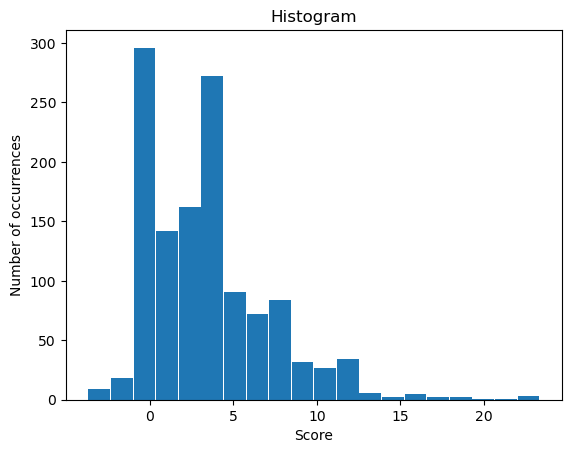

In [38]:
# Score histogram
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
#from io import StringIO
import io

def show(p):
    img = io.StringIO()
    p.savefig(img, format='svg')
    img.seek(0)
#    print ("%html <div style='width:600px'>" + img.buf() + "</div>")

# Obtain a histogram with 10 groups
x,y = dfSE.select(colPoints).rdd.flatMap(lambda x:x).histogram(20)

# Clean the graph
plt.gcf().clear()

plt.bar(x[:-1], y, width=1.3)
plt.xlabel(u'Score')
plt.ylabel(u'Number of occurrences')
plt.title(u'Histogram')

show(plt)


## Complex types

Spark works with three types of complex data: `structs`, `arrays` and `maps`

### Structs

DataFrames inside DataFrames

In [39]:
from pyspark.sql.functions import struct
# Create a new DF with a column that combines two existing columns
colNumViews = col("numViewed")
colNReplies = col("nAnswers")
dfStruct = dfSE.select(colId, colNumViews, colNReplies, struct(colNumViews, colNReplies)\
               .alias("Viewed_Replied"))
dfStruct.show(5)

+----+---------+--------+--------------+
|  id|numViewed|nAnswers|Viewed_Replied|
+----+---------+--------+--------------+
|1165|        0|       0|        {0, 0}|
|1166|       61|       1|       {61, 1}|
|1167|        0|       0|        {0, 0}|
|1168|      187|       4|      {187, 4}|
|1169|        0|       0|        {0, 0}|
+----+---------+--------+--------------+
only showing top 5 rows



In [40]:
# Obtain a field of the combined column
dfStruct.select(col("Viewed_Replied").getField("numViewed")).show(5)

+------------------------+
|Viewed_Replied.numViewed|
+------------------------+
|                       0|
|                      61|
|                       0|
|                     187|
|                       0|
+------------------------+
only showing top 5 rows




### Arrays

Arrays let us work with data as if they were a Python array.

*Example*

Obtain the number of *tags* for each question with an accepted reply and replace the ``&lt;`` and ``&gt;`` by  ''<'' and ''>''

  - "tags" from each question are saved in a concatenated way, separated by   ''<'' and ''>'', codified as ``&lt;`` and ``&gt;``

`&lt;english-comparison&gt;&lt;translation&gt;&lt;phrase-request&gt;`

In [41]:
# First, obtain a DataFrame without null tags
dfSE.show(10)
dfNotNullTags = dfSE.dropna("any", subset=["tags"])
dfNotNullTags.show(10)

+-----+--------------------+------+--------------------+-----+--------------------+---------+--------------------+--------------------+--------+----------------+--------+----+
|nComs|        lastActivity|userId|                body|score|       Creation_date|numViewed|               title|                tags|nAnswers|acceptedAnswerId|postType|  id|
+-----+--------------------+------+--------------------+-----+--------------------+---------+--------------------+--------------------+--------+----------------+--------+----+
|    4|2013-11-11 18:21:...|    17|&lt;p&gt;The infi...|   23|2013-11-10 19:37:...|        0|                null|                null|       0|            null|       2|1165|
|    5|2013-11-10 20:31:...|    12|&lt;p&gt;Come cre...|    1|2013-11-10 19:44:...|       61|Cosa sapreste dir...| &lt;word-choice&gt;|       1|            null|       1|1166|
|    2|2013-11-10 20:31:...|    17|&lt;p&gt;Il verbo...|    5|2013-11-10 19:58:...|        0|                null|      

In [42]:
# Add a column with all tags splitted
from pyspark.sql.functions import split
colTags = col("tags")
dfTags = dfNotNullTags.withColumn("tag_array", split(colTags, "&gt;&lt;"))
dfTags.select(colTags, col("tag_array")).show(10, False)

+-------------------------------------------------------------------+---------------------------------------------------------+
|tags                                                               |tag_array                                                |
+-------------------------------------------------------------------+---------------------------------------------------------+
|&lt;word-choice&gt;                                                |[&lt;word-choice&gt;]                                    |
|&lt;english-comparison&gt;&lt;translation&gt;&lt;phrase-request&gt;|[&lt;english-comparison, translation, phrase-request&gt;]|
|&lt;usage&gt;&lt;verbs&gt;                                         |[&lt;usage, verbs&gt;]                                   |
|&lt;usage&gt;&lt;tenses&gt;&lt;english-comparison&gt;              |[&lt;usage, tenses, english-comparison&gt;]              |
|&lt;usage&gt;&lt;punctuation&gt;                                   |[&lt;usage, punctuation&gt;]       

In [43]:
from pyspark.sql.functions import size
# Show the number of tags of each entry
colTag_array = col("tag_array")
dfTags.select(colTag_array, size(colTag_array)).show(5, False)

+---------------------------------------------------------+---------------+
|tag_array                                                |size(tag_array)|
+---------------------------------------------------------+---------------+
|[&lt;word-choice&gt;]                                    |1              |
|[&lt;english-comparison, translation, phrase-request&gt;]|3              |
|[&lt;usage, verbs&gt;]                                   |2              |
|[&lt;usage, tenses, english-comparison&gt;]              |3              |
|[&lt;usage, punctuation&gt;]                             |2              |
+---------------------------------------------------------+---------------+
only showing top 5 rows



In [44]:
# Show the second tag of each entry
dfTags.selectExpr("tag_array", "tag_array[1]").show(5, False)

+---------------------------------------------------------+---------------+
|tag_array                                                |tag_array[1]   |
+---------------------------------------------------------+---------------+
|[&lt;word-choice&gt;]                                    |null           |
|[&lt;english-comparison, translation, phrase-request&gt;]|translation    |
|[&lt;usage, verbs&gt;]                                   |verbs&gt;      |
|[&lt;usage, tenses, english-comparison&gt;]              |tenses         |
|[&lt;usage, punctuation&gt;]                             |punctuation&gt;|
+---------------------------------------------------------+---------------+
only showing top 5 rows



In [45]:
from pyspark.sql.functions import array_contains
# Look up whether the word "usage" appears in the tags
dfTags.withColumn("With_usage", array_contains(colTag_array, "&lt;usage"))\
      .select(colTag_array, col("With_usage")).show(5, False)

+---------------------------------------------------------+----------+
|tag_array                                                |With_usage|
+---------------------------------------------------------+----------+
|[&lt;word-choice&gt;]                                    |false     |
|[&lt;english-comparison, translation, phrase-request&gt;]|false     |
|[&lt;usage, verbs&gt;]                                   |true      |
|[&lt;usage, tenses, english-comparison&gt;]              |true      |
|[&lt;usage, punctuation&gt;]                             |true      |
+---------------------------------------------------------+----------+
only showing top 5 rows



In [46]:
from pyspark.sql.functions import explode
# Convert each tag in a row
dfTagsRows = dfTags.withColumn("Tags2", explode(colTag_array))
dfTagsRows.select(colTags, col("Tags2")).show(10, False)

+-------------------------------------------------------------------+----------------------+
|tags                                                               |Tags2                 |
+-------------------------------------------------------------------+----------------------+
|&lt;word-choice&gt;                                                |&lt;word-choice&gt;   |
|&lt;english-comparison&gt;&lt;translation&gt;&lt;phrase-request&gt;|&lt;english-comparison|
|&lt;english-comparison&gt;&lt;translation&gt;&lt;phrase-request&gt;|translation           |
|&lt;english-comparison&gt;&lt;translation&gt;&lt;phrase-request&gt;|phrase-request&gt;    |
|&lt;usage&gt;&lt;verbs&gt;                                         |&lt;usage             |
|&lt;usage&gt;&lt;verbs&gt;                                         |verbs&gt;             |
|&lt;usage&gt;&lt;tenses&gt;&lt;english-comparison&gt;              |&lt;usage             |
|&lt;usage&gt;&lt;tenses&gt;&lt;english-comparison&gt;              |t

In [47]:
# Remove symbols &lt; y &gt;
from pyspark.sql.functions import regexp_replace
dfTags = dfTagsRows.withColumn("Tags_splitted", regexp_replace("Tags2", "&[l,g]t;", ""))\
                   .drop("Tags2")
dfTags.select(colTags, col("Tags_splitted")).show(10, False)

+-------------------------------------------------------------------+------------------+
|tags                                                               |Tags_splitted     |
+-------------------------------------------------------------------+------------------+
|&lt;word-choice&gt;                                                |word-choice       |
|&lt;english-comparison&gt;&lt;translation&gt;&lt;phrase-request&gt;|english-comparison|
|&lt;english-comparison&gt;&lt;translation&gt;&lt;phrase-request&gt;|translation       |
|&lt;english-comparison&gt;&lt;translation&gt;&lt;phrase-request&gt;|phrase-request    |
|&lt;usage&gt;&lt;verbs&gt;                                         |usage             |
|&lt;usage&gt;&lt;verbs&gt;                                         |verbs             |
|&lt;usage&gt;&lt;tenses&gt;&lt;english-comparison&gt;              |usage             |
|&lt;usage&gt;&lt;tenses&gt;&lt;english-comparison&gt;              |tenses            |
|&lt;usage&gt;&lt;ten

In [48]:
# Number of entries with the "word-choice" tag
print("Number of entries with the word-choice tag = {0}"
      .format(dfTags
      .filter(col("Tags_splitted") == "word-choice")
      .count()))

Number of entries with the word-choice tag = 57


### Maps

They are created from columns that work as key-value pairs.

In [49]:
from pyspark.sql.functions import create_map
# Create a column with a key-value map
# key: id, value: body
dfMap = dfSE.select(create_map(col("Creation_date"), col("lastActivity"))\
            .alias("Dates"))
dfMap.show(5, False)

+----------------------------------------------------+
|Dates                                               |
+----------------------------------------------------+
|{2013-11-10 19:37:54.187 -> 2013-11-11 18:21:10.903}|
|{2013-11-10 19:44:53.797 -> 2013-11-10 20:31:00.177}|
|{2013-11-10 19:58:02.1 -> 2013-11-10 20:31:00.177}  |
|{2013-11-10 22:03:41.027 -> 2014-07-25 13:15:02.27} |
|{2013-11-10 22:15:17.693 -> 2013-11-10 22:15:17.693}|
+----------------------------------------------------+
only showing top 5 rows



In [50]:
# We can conduct a search using the key
dfMap.selectExpr("Dates['2013-11-10 19:58:02.1']").show(5, False)

+----------------------------+
|Dates[2013-11-10 19:58:02.1]|
+----------------------------+
|null                        |
|null                        |
|2013-11-10 20:31:00.177     |
|null                        |
|null                        |
+----------------------------+
only showing top 5 rows



## Window functions

Similar to aggregation functions, they operate in groups of rows, returning a single value for each row. This allows, among others:

  - To obtain moving averages
  - To calculate cumulative sums 
  - To access values higher than the current row value

Basically, a window function calculates a value for each input row from a table based on a group of rows, called *frame*.

As window functions we can use the aggregation functions previously seen as well as other additional functions (``cume_dist``, ``dense_rank``, ``lag``, ``lead``, ``ntile``, ``percent_rank``, ``rank``, ``row_number``) specified as *Window function* in https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html#window

#### Example 1
From the ``dfQuestionWithAcceptedReply`` DataFrame, show the score (column "points") maximum per user and for each question, the difference between the question score and the user's maximum score.


In [51]:
from pyspark.sql.window import Window

# Specify the windows to partition the rows by the userId column
window = Window.partitionBy(colUserId)
print(type(window))


<class 'pyspark.sql.window.WindowSpec'>


In [52]:
# Create a column with the maximum score per user
colMaxPoints = F.max(colPoints).over(window)
print(type(colMaxPoints))

<class 'pyspark.sql.column.Column'>


In [53]:
# Obtain a new DataFrame including the maximum score per user and the difference 
# between this maximum and each question score
dfQuestionWithAcceptedReply.select(colUserId, colId.alias("Question"), 
                          colPoints, colMaxPoints.alias("maxPerUser"))\
                  .withColumn("Difference", colMaxPoints-colPoints)\
                  .orderBy(colUserId, colId)\
                  .show(30)

+------+--------+-----+----------+----------+
|userId|Question|score|maxPerUser|Difference|
+------+--------+-----+----------+----------+
|     8|       1|   20|        20|         0|
|     8|    1192|   13|        20|         7|
|     8|    1321|   10|        20|        10|
|     8|    1365|    3|        20|        17|
|    12|      19|    2|        10|         8|
|    12|      89|    4|        10|         6|
|    12|    1146|    1|        10|         9|
|    12|    1329|    2|        10|         8|
|    12|    1352|    5|        10|         5|
|    12|    1398|    2|        10|         8|
|    12|    1400|    1|        10|         9|
|    12|    1420|    0|        10|        10|
|    12|    1437|    1|        10|         9|
|    12|    1452|   -2|        10|        12|
|    12|    1466|   10|        10|         0|
|    12|    1535|    3|        10|         7|
|    12|    1612|    4|        10|         6|
|    12|    1621|    5|        10|         5|
|    12|    1662|    0|        10|

#### Example 2
Show for each user and question from the ``dfQuestionWithAcceptedReply`` DataFrame  the number of days spent between the previous user question until the current one, and from the current one to the following one.

In [54]:
# Specify the window to partition the rows by the userId column and sort them by creation day
window = Window.partitionBy(colUserId).orderBy(colCreationDate)

In [55]:
# Create a column to reference the previous question (in date)
PreviousCol = F.lag(colCreationDate, 1).over(window)
# Create a column to reference the following question (in date)
FollowingCol = F.lead(colCreationDate, 1).over(window)

# Show for each user and question the id of the previous and following questions
dfQuestionWithAcceptedReply.select(colUserId, colId, colCreationDate.alias("Creation Date"), 
                          F.datediff(colCreationDate,PreviousCol).alias("Days from"), 
                          F.datediff(FollowingCol,colCreationDate).alias("Days until"))\
                  .orderBy(colUserId, colId)\
                  .show(30, truncate=False)

+------+----+-----------------------+---------+----------+
|userId|id  |Creation Date          |Days from|Days until|
+------+----+-----------------------+---------+----------+
|8     |1   |2013-11-05 20:22:07.323|null     |6         |
|8     |1192|2013-11-11 21:01:13.34 |6        |9         |
|8     |1321|2013-11-20 16:42:19.91 |9        |3         |
|8     |1365|2013-11-23 09:09:04.993|3        |null      |
|12    |19  |2013-11-05 22:38:26.767|null     |2         |
|12    |89  |2013-11-07 19:22:45.923|2        |2         |
|12    |1146|2013-11-09 21:24:03.593|2        |11        |
|12    |1329|2013-11-20 22:20:58.87 |11       |2         |
|12    |1352|2013-11-22 08:08:34.063|2        |4         |
|12    |1398|2013-11-26 20:08:13.423|4        |1         |
|12    |1400|2013-11-27 08:05:11.63 |1        |2         |
|12    |1420|2013-11-29 21:15:01.09 |2        |2         |
|12    |1437|2013-12-01 18:11:27.07 |2        |6         |
|12    |1452|2013-12-07 22:04:57.82 |6        |2        

## User-Defined Functions (UDFs)

If we need a function that is not implemented, we can create our own function to operate on columns.

**Note:**
  - UDFs in Python may be quite inefficient, due to the data serialisation in Python
  - It is recommended to code them in Scala or Java (and then call them from Python)


#### Example

User UDFs to obtain the number of *tags* for each question and change the ``&lt;`` and ``&gt;`` by  ''<'' and ''>''

  - The "tags" from each question are stored concatenated, separated by  ''<'' and ''>'', and coded as ``&lt;`` and ``&gt;``

`&lt;english-comparison&gt;&lt;translation&gt;&lt;phrase-request&gt;`

To count the number of tags, it is enough to count the number of times ``&lt;`` appears in the string.

In [56]:
colTags = col("tags")
# Obtain a DataFrame without null tags
dfNoNullTags = dfSE.na.drop("any", subset=["tags"])

In [57]:
from pyspark.sql.functions import udf

# Define a function that returns the number of &lt; in a string
def countTags(tags):
    return tags.count('&lt;')

# Define a function that replaces &lt and &gt by < and >
def replaceTags(tags):
    return tags.replace('&lt;', '<').replace('&gt;', '>')

# Create udfs from these functions
udfCountTags = udf(countTags)
udfReplaceTags = udf(replaceTags)

In [58]:
dfNoNullTags.select(udfReplaceTags(colTags).alias("Tags"),\
                          udfCountTags(colTags).alias("nTags"))\
                  .show(truncate=False)


+-------------------------------------------------+-----+
|Tags                                             |nTags|
+-------------------------------------------------+-----+
|<word-choice>                                    |1    |
|<english-comparison><translation><phrase-request>|3    |
|<usage><verbs>                                   |2    |
|<usage><tenses><english-comparison>              |3    |
|<usage><punctuation>                             |2    |
|<usage><tenses>                                  |2    |
|<history><english-comparison>                    |2    |
|<idioms><etymology>                              |2    |
|<idioms><regional>                               |2    |
|<grammar>                                        |1    |
|<prepositions><etymology>                        |2    |
|<punctuation><list><writing>                     |3    |
|<grammar>                                        |1    |
|<usage><punctuation><sentences>                  |3    |
|<grammar><ver

**NOTE:** Only Python and Swift are officially supported languages on Colaboratory. If we want to create the UDFs in Scala using Colaboratory, please follow [this instructions](https://medium.com/@shadaj/machine-learning-with-scala-in-google-colaboratory-e6f1661f1c88) to install and configure a Scala kernel. Otherwise, the following two code blocks will not work.

In [ ]:
// Create the previous functions in Scala
def countTagsSc(tags:String):Int = tags.split("&lt;").size - 1
def replaceTagsSc(tags:String):String = tags.replace("&lt;", "<").replace("&gt;", ">")

// Register those functions as a Spark SQL function
spark.udf.register("udfCountTagsSc", countTagsSc(_:String):Int)
spark.udf.register("udfReplaceTagsSc", replaceTagsSc(_:String):String)

In [ ]:
dfNoNullTags.printSchema()
# Call IDFs Scala using an expression
dfNoNullTags.selectExpr("udfReplaceTagsSc(tags) AS Tags",
                              "udfCountTagsSc(tags) AS nTags")\
                  .show(truncate=False)

## Using SQL commands

SQL commands executed from Spark are converted to operations on DataFrames

 - It is possible to run remote commands using the JDBC/ODBC server [Thrift](https://spark.apache.org/docs/latest/sql-programming-guide.html#distributed-sql-engine)
 - It can also work with stored data in [Apache Hive](https://spark.apache.org/docs/latest/sql-programming-guide.html#hive-tables)

To use SQL commands on a DataFrame , the DataFrame must be registered as a *table* or *view*.

 - The view can be created as a temporary one (it is deleted when the session ends) or as a global one (kept between sessions).


In [4]:
# Registers the dfQuestionWithAcceptedReply DataFrame as a temporary view
dfQuestionWithAcceptedReply.createOrReplaceTempView("table_QuestionWithAcceptedReply")

# Create a table with the data stored in Parquet
spark.sql("CREATE TABLE table_SE USING PARQUET OPTIONS (path '"+os.environ["DRIVE_DATA"] + "dfSE.parquet" + "')")


NameError: name 'dfQuestionWithAcceptedReply' is not defined

In [62]:
spark.sql("SELECT * FROM table_SE").printSchema()

root
 |-- nComs: integer (nullable = true)
 |-- lastActivity: timestamp (nullable = true)
 |-- userId: long (nullable = true)
 |-- body: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- Creation_date: timestamp (nullable = true)
 |-- numViewed: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- nAnswers: integer (nullable = true)
 |-- acceptedAnswerId: long (nullable = true)
 |-- postType: byte (nullable = true)
 |-- id: long (nullable = true)



In [63]:
# Run a SQL command on the table contents
dfUser100 = spark.sql("""SELECT userId,id FROM table_SE
                         WHERE userId >= 100""")
dfUser100.show(5)

+------+---+
|userId| id|
+------+---+
+------+---+



In [64]:
# Show the created tables
spark.sql("SHOW TABLES").show()

+---------+--------------------+-----------+
|namespace|           tableName|isTemporary|
+---------+--------------------+-----------+
|  default|            table_se|      false|
|         |table_questionwit...|       true|
+---------+--------------------+-----------+



In [65]:
# Create a new DataFrame from one of the tables
dfFromTable = spark.sql("SELECT * FROM table_QuestionWithAcceptedReply")
dfFromTable.show(5)

+-----+--------------------+------+--------------------+-----+--------------------+---------+--------------------+--------------------+--------+----------------+--------+----+
|nComs|        lastActivity|userId|                body|score|    Date_of_creation|numViewed|               title|                tags|nAnswers|acceptedAnswerId|postType|  id|
+-----+--------------------+------+--------------------+-----+--------------------+---------+--------------------+--------------------+--------+----------------+--------+----+
|    1|2014-07-25 13:15:...|   154|&lt;p&gt;As part ...|   11|2013-11-10 22:03:...|      187|Ironic constructi...|&lt;english-compa...|       4|            1170|       1|1168|
|    9|2014-01-05 11:13:...|    63|&lt;p&gt;When I w...|    5|2013-11-11 10:28:...|      122|Is &quot;scancell...|&lt;usage&gt;&lt;...|       3|            1181|       1|1173|
|    1|2014-01-16 19:56:...|    63|&lt;p&gt;Suppose ...|    4|2013-11-11 11:31:...|      114|How should I tran...|&lt;us

In [66]:
spark.sql("DROP TABLE IF EXISTS table_QuestionWithAcceptedReply")
spark.sql("DROP TABLE IF EXISTS table_SE")

spark.sql("SHOW TABLES").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
+---------+---------+-----------+





---

# Exercises


## Exercise 4.1: Pi Estimation

Using the Monte Carlo method, estimate the value of Pi. Use the random() method from the random class.

In [56]:
import random
import numpy as np
 
INTERVAL = 1000
 
circle_points = 0
square_points = 0
 
# Total Random numbers generated= possible x
# values* possible y values
for i in range(INTERVAL**2):
 
    # Randomly generated x and y values from a
    # uniform distribution
    # Range of x and y values is -1 to 1
    rand_x = random.uniform(-1, 1)
    rand_y = random.uniform(-1, 1)
 
    # Distance between (x, y) from the origin
    origin_dist = rand_x**2 + rand_y**2
 
    # Checking if (x, y) lies inside the circle
    if origin_dist <= 1:
        circle_points += 1
 
    square_points += 1
 
    # Estimating value of pi,
    # pi= 4*(no. of points generated inside the
    # circle)/ (no. of points generated inside the square)
    pi = 4 * circle_points / square_points
    # ef = circle_points / INTERVAL**2
    # pi = 4 * ef
    
    #print(rand_x, rand_y, circle_points, square_points, "-", pi)
# print("\n")
 
print("Final Estimation of Pi=", pi)


Final Estimation of Pi= 3.13974


In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ex4').getOrCreate()

/usr/local/lib/python3.9/dist-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/23 22:07:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
n=100000000
rdd = spark.sparkContext.parallelize(range(0, n))

In [75]:
import random
from operator import add


def func(x):
    rand_x = random.uniform(0, 1)
    rand_y = random.uniform(0, 1)

    origin_dist = rand_x**2 + rand_y**2

    return 1 if origin_dist < 1 else 0
    

count = rdd.map(func).reduce(add)

pi = 4 * count / n
pi

3.14154416

## Exercise 4.2: Inspect a log file

Upload the file /var/log/syslog from your computer to this notebook. Then, select only the "bad lines": WARNING and ERROR messages.

In [7]:
read_file = spark.read.text(os.environ["DRIVE_DATA"] + "syslog")

In [8]:
import os

os.environ["DRIVE_DATA"] = "./data/"

In [9]:
read_file.show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                     |
+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|Nov 13 18:38:06 student-laptop rsyslogd: [origin software="rsyslogd" swVersion="8.2001.0" x-pid="934" x-info="https://www.rsyslog.com"] rsyslogd was HUPed|
|Nov 13 18:38:06 student-laptop systemd[1]: logrotate.service: Succeeded.                                                                                  |
|Nov 13 18:38:06 student-laptop systemd[1]: Finished Rotate log files.                                                                                     |
|Nov 13 18:38:06 student-laptop systemd[1]: Finished Wait 

In [10]:
read_file.printSchema()

root
 |-- value: string (nullable = true)



In [11]:
read_file.filter(read_file.value.contains("WARNING") == True).show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                               |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Nov 13 18:38:13 student-laptop ovpn-cytech.students[6282]: WARNING: file '/data/CYTECH-VPN-CLE-PERSONNELLE/client.p12' is group or others accessible                                                              

In [12]:
read_file.select(read_file.value).collect()

[Row(value='Nov 13 18:38:06 student-laptop rsyslogd: [origin software="rsyslogd" swVersion="8.2001.0" x-pid="934" x-info="https://www.rsyslog.com"] rsyslogd was HUPed'),
 Row(value='Nov 13 18:38:06 student-laptop systemd[1]: logrotate.service: Succeeded.'),
 Row(value='Nov 13 18:38:06 student-laptop systemd[1]: Finished Rotate log files.'),
 Row(value='Nov 13 18:38:06 student-laptop systemd[1]: Finished Wait until snapd is fully seeded.'),
 Row(value='Nov 13 18:38:06 student-laptop systemd[1]: Condition check resulted in Auto import assertions from block devices being skipped.'),
 Row(value="Nov 13 18:38:06 student-laptop NetworkManager[915]: <warn>  [1668361086.7958] keyfile: 802-1x.ca-cert: certificat ou fichier clé «\xa0file:///data/EISTI-CERTIFICATE/eisti_eduroam_ca.pem\xa0» n'existe pas"),
 Row(value='Nov 13 18:38:06 student-laptop NetworkManager[915]: <info>  [1668361086.8029] device (lo): carrier: link connected'),
 Row(value='Nov 13 18:38:06 student-laptop NetworkManager[915]: 

In [13]:
read_file.select(read_file.value.alias("Alos")).show(3, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|Alos                                                                                                                                                      |
+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|Nov 13 18:38:06 student-laptop rsyslogd: [origin software="rsyslogd" swVersion="8.2001.0" x-pid="934" x-info="https://www.rsyslog.com"] rsyslogd was HUPed|
|Nov 13 18:38:06 student-laptop systemd[1]: logrotate.service: Succeeded.                                                                                  |
|Nov 13 18:38:06 student-laptop systemd[1]: Finished Rotate log files.                                                                                     |
+---------------------------------------------------------

In [101]:
import pyspark.sql.functions as F

read_file.select(F.split(read_file.value, ':', 3)[0].alias("message"), F.split(read_file.value, ':', 3)[1].alias("details")).show(3, truncate=False)

+---------+-------+
|message  |details|
+---------+-------+
|Nov 13 18|38     |
|Nov 13 18|38     |
|Nov 13 18|38     |
+---------+-------+
only showing top 3 rows

